In [31]:
from lifelines import CoxPHFitter
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import csv
import os
import math
from lifelines.utils import k_fold_cross_validation
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import scipy.stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from statsmodels.stats.weightstats import ztest
from scipy import interp
import subprocess
import re
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split 

## Creazione dei dataset da Excel

file=pd.read_excel("TCGA-OV-Clinical-Table_S1.2.xlsx", sheetname="KeyclinicalDAta", index_col=0)

In [32]:
sens=pd.read_csv('clintab_GMQL/gene_exprs/ss_surv.csv', sep='\t')
#sens['class']=np.zeros(sens.shape[0], dtype=int)
#sens.head()

In [33]:
senl=pd.read_csv('clintab_GMQL/gene_exprs/sl_surv.csv', sep='\t')
#senl['class']=np.full(senl.shape[0], 2)
#senl.head()

In [34]:
res=pd.read_csv('clintab_GMQL/gene_exprs/res_surv.csv', sep='\t')
#res['class']=np.ones(res.shape[0], dtype=int)
#res.head()

In [35]:
sensitive=senl.append(sens, ignore_index=True)
all_dset1=res.append(sensitive, ignore_index=True)

all_dset1.head()

,patient,chrom,start,stop,ensemble_id,entrez_id,gene_symbol,fpkm,pfs,event
0,R_00000,1,11869,14409,ENSG00000223972.5,100287102.0,DDX11L1,0.000000,4.983607,1
1,R_00000,1,14404,29570,ENSG00000227232.5,653635.0,WASH7P,1.695909,4.983607,1
2,R_00000,1,17369,17436,ENSG00000278267.1,102465910.0,MIR6859-3,4.443128,4.983607,1
3,R_00000,1,29554,31109,ENSG00000243485.3,NaN,RP11-34P13.3,0.024660,4.983607,1
4,R_00000,1,30366,30503,ENSG00000274890.1,100422831.0,MIR1302-9,0.000000,4.983607,1


## Significant features

In [36]:
res_vs_sens=pd.read_csv("new_data/gene_exprs/r_ss_bonf_ge.csv", delimiter=',')
res_vs_senl=pd.read_csv("new_data/gene_exprs/r_sl_bonf_ge.csv", delimiter=',')
senl_vs_sens=pd.read_csv("new_data/gene_exprs/sl_ss_bonf_ge.csv", delimiter=',')

In [37]:
senx=senl_vs_sens.append(res_vs_senl, ignore_index=True, sort=True)
all_genes=senx.append(res_vs_sens, ignore_index=True, sort=True)
#all_genes.head()
all_genes.shape

(91, 8)

In [38]:
ciao = all_genes[all_genes.columns[0:1]] 
#ciao.head()
ciao.shape

(91, 1)

### Dataset from list of significant genes

In [39]:
lista1=set(ciao['ensemble_id'])
len(lista1)
#lista1=new_f
#len(lista1)

83

In [40]:
dset_res = res[res.ensemble_id.isin(lista1)]
res1=pd.DataFrame(dset_res)
#res1.head()

In [41]:
resdf=res1.pivot(index="patient", columns="ensemble_id", values="fpkm")
genes = resdf.columns.tolist()
resdf.loc[:, (resdf != 0.0).any(axis=0)]
#resdf.head()
resdf.shape

(62, 83)

In [42]:
dset_sens = sens[sens.ensemble_id.isin(lista1)]
sens1=pd.DataFrame(dset_sens)
#sens1.head()

In [43]:
sensdf=sens1.pivot(index="patient", columns="ensemble_id", values="fpkm")
sensdf = sensdf[genes]
sensdf.loc[:, (sensdf != 0.0).any(axis=0)]
#sensdf.head()
sensdf.shape

(107, 83)

In [44]:
dset_senl = senl[senl.ensemble_id.isin(lista1)]
senl1=pd.DataFrame(dset_senl)
#senl1.head()

In [45]:
senldf=senl1.pivot(index="patient", columns="ensemble_id", values="fpkm")
senldf = senldf[genes]
senldf.loc[:, (senldf != 0.0).any(axis=0)]
#senldf.head()
senldf.shape

(34, 83)

In [46]:
sen_conc=pd.concat([senldf, sensdf])
all_conc=pd.concat([sen_conc, resdf])

In [47]:
#all_conc.head()
all_conc.shape

(203, 83)

### Adding pfs, class, event

In [48]:
lista2=set(all_dset1['pfs'])
lista3=set(all_dset1['event'])

In [49]:
gr=all_dset1.groupby(['patient'])

In [50]:
pfs=[]
e=[]
#classes=[]
for p in gr.groups.keys():
    g=gr.get_group(p)
    pfs.append(g['pfs'].unique()[0])
    e.append(g['event'].unique()[0])
    #classes.append(g['class'].unique()[0])
   

In [51]:
all_conc['pfs']=pfs
all_conc['event']=e
#all_conc['class']=classes

#all_conc.to_csv(path_or_buf ='all_conc_surv.csv', sep='\t', header=all_conc.columns, index=False)
#all_conc.head()

In [ ]:
x=all_conc.copy()
x=x.drop(['pfs', 'event', 'ENSG00000197958.11', 'ENSG00000197903.7'], axis=1) #questo serve per plottare la correlation matrix, quello sopra per SA
x.head()
#x=pd.DataFrame(x)

In [ ]:
import seaborn as sns
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [52]:
x=all_conc.copy() #queste sono quelle della mild Bonf
x=x.drop(['ENSG00000197958.11', 'ENSG00000197903.7','ENSG00000099968.16','ENSG00000157600.10','ENSG00000099219.12',
          'ENSG00000044574.7','ENSG00000183578.5','ENSG00000182253.13','ENSG00000143919.13','ENSG00000165280.14',
          'ENSG00000151812.13','ENSG00000163251.3','ENSG00000249853.6','ENSG00000137364.4','ENSG00000143013.11',
          'ENSG00000171311.11','ENSG00000183695.2','ENSG00000135413.7','ENSG00000149428.17','ENSG00000166444.16',
          'ENSG00000100307.11','ENSG00000133597.8','ENSG00000178175.10','ENSG00000233927.4','ENSG00000106144.18',
          'ENSG00000118242.14','ENSG00000204580.10','ENSG00000112972.13','ENSG00000213859.4','ENSG00000264668.1',
          'ENSG00000137522.16','ENSG00000116016.12','ENSG00000142676.11','ENSG00000146859.6','ENSG00000276180.1',
          'ENSG00000255508.6','ENSG00000128052.8','ENSG00000150455.12','ENSG00000172572.6','ENSG00000178814.14',
          'ENSG00000090861.14','ENSG00000155660.9','ENSG00000125864.10','ENSG00000163554.10','ENSG00000124659.6',
          'ENSG00000241978.8','ENSG00000148690.11','ENSG00000084234.15','ENSG00000104290.9','ENSG00000173335.4',
          'ENSG00000182890.4','ENSG00000281674.1','ENSG00000119888.9','ENSG00000198336.8','ENSG00000138326.17',
          'ENSG00000065060.15','ENSG00000107185.9','ENSG00000204983.11','ENSG00000187783.10','ENSG00000189233.10',
          'ENSG00000125046.13','ENSG00000130255.11','ENSG00000143947.11', 'ENSG00000253250.2','ENSG00000144713.11',
          'ENSG00000155016.16','ENSG00000085276.16','ENSG00000134504.11','ENSG00000244731.6','ENSG00000261427.5',
          'ENSG00000081026.17','ENSG00000173227.12','ENSG00000100084.13','ENSG00000138867.15','ENSG00000248487.7',
          'ENSG00000122783.15'], axis=1)
x_all=x.values

x.head()

ensemble_id,ENSG00000090520.9,ENSG00000114315.3,ENSG00000137393.9,ENSG00000137440.4,ENSG00000177383.4,ENSG00000181698.3,ENSG00000250264.1,pfs,event
patient,,,,,,,,,
SL_00000,7.975547,36.479357,6.606148,0.364829,51.721935,0.0,0.043641,4.983607,1
SL_00001,29.917335,69.536179,12.642084,3.166293,91.739234,0.0,0.036569,8.918033,1
SL_00002,19.228730,40.038578,13.039530,0.263416,70.285288,0.0,0.005514,7.704918,1
SL_00003,7.148109,19.463238,6.373900,0.932998,20.633694,0.0,0.054347,8.885246,1
SL_00004,22.116999,27.017489,6.487276,0.100454,100.913090,0.0,0.050468,8.295082,1


In [53]:
#ricordarti che alla riga print(scaler.fit(all_conc))!

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(x))
StandardScaler(copy=True, with_mean=True, with_std=True)
print(scaler.mean_)
df_scal=scaler.transform(x)
df_scal=pd.DataFrame(df_scal, columns=x.columns)
print(df_scal)

StandardScaler(copy=True, with_mean=True, with_std=True)
[1.45687844e+01 3.05771491e+01 1.28618976e+01 2.21695205e+00
 5.20022906e+01 4.06564778e-04 4.02048313e-02 2.09403214e+01
 8.76847291e-01]
ensemble_id  ENSG00000090520.9  ENSG00000114315.3  ENSG00000137393.9  \
0                    -1.016000           0.272509          -0.492610   
1                     2.365169           1.798762          -0.017309   
2                     0.718085           0.436840           0.013988   
3                    -1.143506          -0.513136          -0.510899   
4                     1.163159          -0.164352          -0.501971   
5                    -0.354817           0.681783           0.239618   
6                     1.243559           0.219613           1.235428   
7                     1.159930           3.608435           1.002639   
8                    -0.298951          -0.237919           0.320744   
9                     1.310613          -0.389704           0.507943   
10          

In [25]:
from sklearn.model_selection import train_test_split
x_new=x.copy()
x_new=x_new.drop('pfs', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_new, x['pfs'], test_size=0.2)
X_train['pfs']= y_train
X_test['pfs']= y_test
#from lifelines.utils.sklearn_adapter import sklearn_adapter
#from lifelines.utils import k_fold_cross_validation, concordance_index

#CoxRegression = sklearn_adapter(CoxPHFitter, event_col='event')
# CoxRegression is a class like the `LinearRegression` class or `SVC` class in scikit-learn

#sk_cph = CoxRegression(penalizer=0.1)
#sk_cph.fit(X_train, y_train)
#sk_cph.fit(X_train, y_train)
#print(sk_cph)

#pred=sk_cph.predict(X_test)
#sk_cph.score(X_test, y_test)

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(X_train, 'pfs', event_col='event', show_progress=True)

Iteration 6: norm_delta = 0.00003, step_size = 1.0000, ll = -603.13660, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 6 iterations.


/home/lalli/anaconda3/lib/python3.6/site-packages/lifelines/utils/__init__.py:1020: ConvergenceWarning: Column(s) ['ENSG00000181698.3'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 162 observations, 19 censored>

In [27]:
res=[]
sens=[]
senl=[]

for p in X_test.index:
    if 'R' in p:
        res.append(p)
    elif 'SS' in p:
        sens.append(p)
    else:
        senl.append(p)

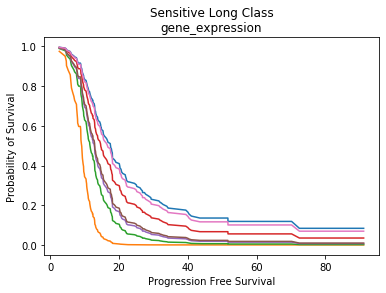

In [30]:
plt.plot(cph.predict_survival_function(X_test.loc[senl]))
plt.xlabel('Progression Free Survival')
plt.ylabel('Probability of Survival')
plt.title('Sensitive Long Class\ngene_expression')
plt.show()

In [ ]:
#all_in=pd.read_csv('all_conc_surv.csv', sep='\t')

In [54]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_scal, duration_col='pfs', event_col='event', show_progress=True, step_size=0.50)
cph.print_summary()
cph.baseline_cumulative_hazard_.shape
#cph.plot()

Iteration 8: norm_delta = 0.00001, step_size = 1.0000, ll = -860.31189, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 8 iterations.
<lifelines.CoxPHFitter: fitted with 203 observations, 0 censored>
      duration col = 'pfs'
         event col = 'event'
         penalizer = 0.0001
number of subjects = 203
  number of events = 203
partial log-likelihood = -860.31
  time fit was run = 2019-10-16 09:08:46 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
ensemble_id                                                                                                        
ENSG00000090520.9  0.20      1.22      0.09            0.03            0.37                1.03                1.45
ENSG00000114315.3  0.27      1.30      0.08            0.10            0.43                1.11                1.54
ENSG00000137393.9  0.16      1.18      0.07            0.03            0.29           

(184, 1)

In [55]:
k_fold = k_fold_cross_validation(cph, df_scal, duration_col='pfs', event_col='event', k=5, predictor='predict_median')

In [ ]:
k_fold

In [ ]:
w=np.mean(k_fold)
w

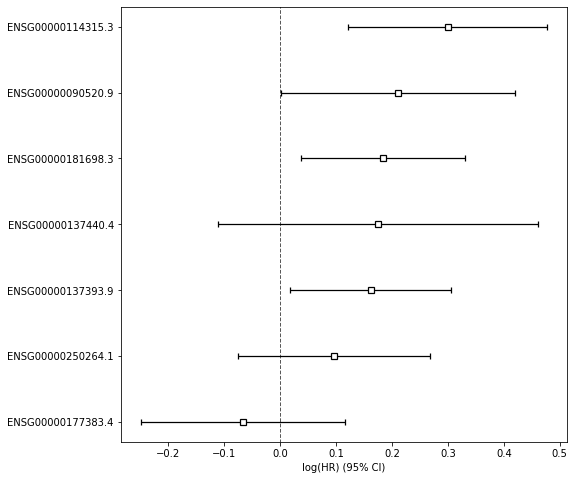

In [56]:
plt.rcParams["figure.figsize"] = [8, 8]
cph.plot()

## Prove

In [ ]:
cph.fit(all_conc, duration_col='pfs', event_col='event', show_progress=True)

cph.plot_covariate_groups('ENSG00000135443.7', [0, 1, 2], cmap='coolwarm')

In [ ]:
#prediction(?)

from lifelines import WeibullAFTFitter
aft_with_elastic_penalty = WeibullAFTFitter(penalizer=4.0, l1_ratio=1.0)
aft_with_elastic_penalty.fit(all_conc, 'pfs', 'event')
aft_with_elastic_penalty.predict_median(all_conc)

aft_with_elastic_penalty.print_summary()

In [ ]:
#Model selection for AFT models
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event')
lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event')
wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event')

print(llf.log_likelihood_) 
print(lnf.log_likelihood_)  
print(wf.log_likelihood_)   


# with some heterogeneity in the ancillary parameters
#ancillary_df = all_conc[['class']]
#llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)

#print(llf.log_likelihood_) 
#print(lnf.log_likelihood_) 
#print(wf.log_likelihood_)  

In [ ]:
all_conc['ENSG00000135443.7']

In [ ]:
cph.check_assumptions(all_conc, p_value_threshold=0.05, show_plots=True)